In [13]:
import numpy as np, pandas as pd, tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from tensorflow.keras.utils import timeseries_dataset_from_array as loader
from UTILS import train_test_split_ts, forward_garch, nll, take_X_y
from arch import arch_model
import pyfiglet
import keras
from sklearn.metrics import mean_squared_error as mse
from keras.layers import Dense, Dropout, SimpleRNN, BatchNormalization, LSTM
from tqdm.auto import tqdm
from keras import Sequential
from thesis import RNN

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18,4)
plt.rcParams['font.size'] = 15

log-realized volatility used as additional feature!
log-realized volatility used as additional feature!


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 5
------------------------------
TRAIN LOSS:  5439
TEST LOSS:  2058
EPOCH: 10
------------------------------
TRAIN LOSS:  5427
TEST LOSS:  2041


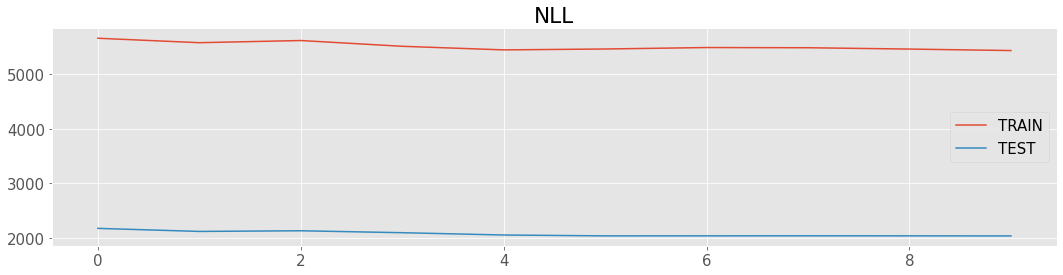

Model: "rnn_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_16 (Bat  multiple                 8         
 chNormalization)                                                
                                                                 
 lstm_10 (LSTM)              multiple                  15120     
                                                                 
 dense_16 (Dense)            multiple                  61        
                                                                 
Total params: 15,189
Trainable params: 15,185
Non-trainable params: 4
_________________________________________________________________
************************************************************
              __  __  ___  ____  _____ _     
             |  \/  |/ _ \|  _ \| ____| |    
             | |\/| | | | | | | |  _| | |    
             | |  | | |_| | |_| | |___| |___ 
         

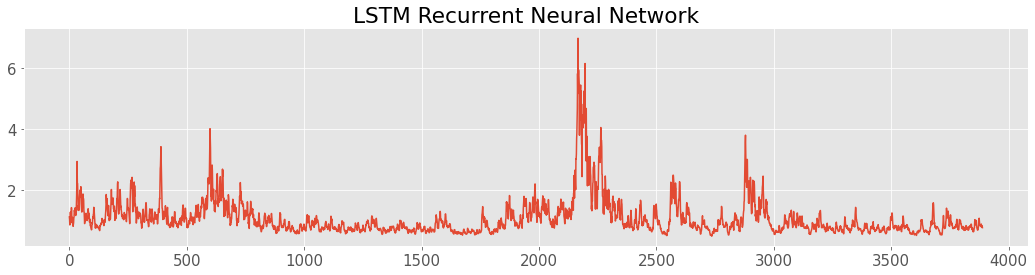

RNN NLL:   5427


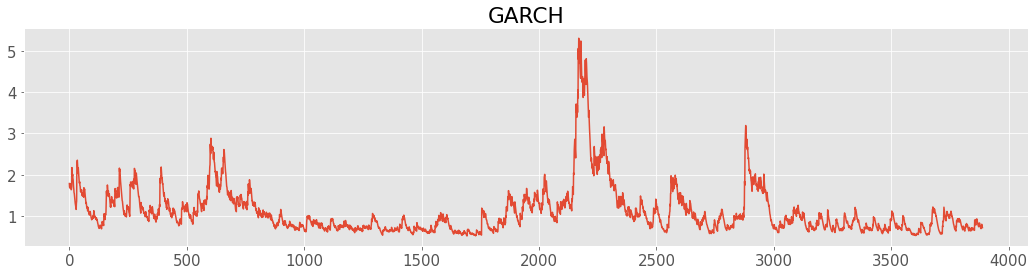

Garch NLL:   5507


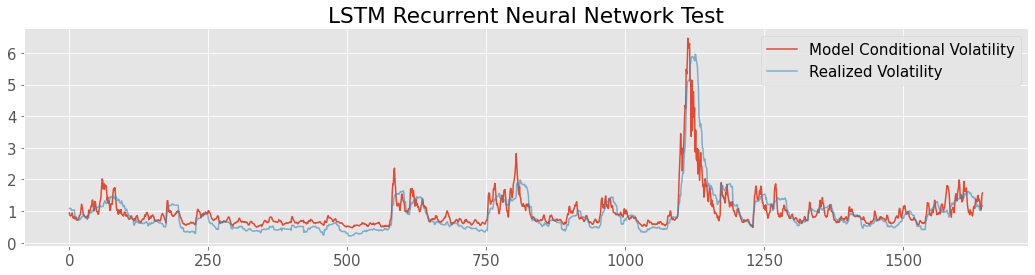

RNN NLL:   2041
RNN RMSE: 0.360


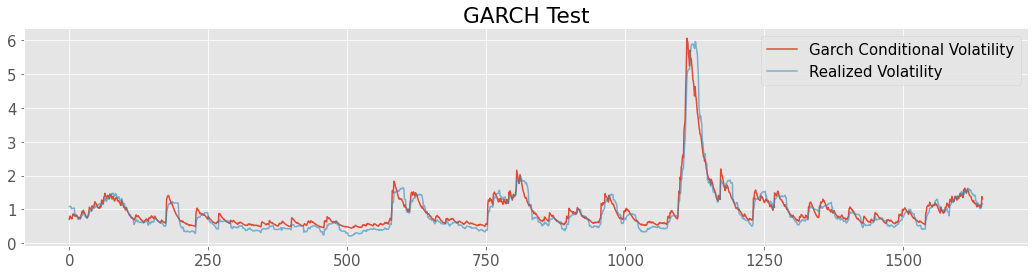

Garch NLL:   2053
Garch RMSE: 0.202


In [65]:
prices = yf.Ticker('^GSPC').history(start = '2000-01-01').Close
rets = 100*(prices.pct_change().dropna())
# rets = 100*(np.log(prices).diff().dropna())
rets_train, rets_test = train_test_split_ts(rets, .7)
#without garch vola as feature
lag = 20
X_train, y_train = take_X_y(rets_train, lag, reshape = False, take_rv = True, log_rv =True )
X_test, y_test = take_X_y(rets_test, lag, reshape = False, take_rv = True, log_rv =True)

X_train, y_train = tf.convert_to_tensor(X_train, dtype  = 'float32'),\
                        tf.convert_to_tensor(y_train, dtype  = 'float32') 

X_test, y_test = tf.convert_to_tensor(X_test, dtype  = 'float32'),\
                        tf.convert_to_tensor(y_test, dtype  = 'float32') 

model = RNN(
    lstm = True,
    hidden_size = [60],
    hidden_activation = 'tanh',
    last_activation = 'exponential',
    dropout = 0.0,
    l1 = 5,
    l2 = 0
)

model.train(
    X_train, 
    y_train,
    X_test,
    y_test,
    epochs = 10,
    bs = 2048,
    lr = .008
)

model.plot_loss()

model.summary()

print(60*'*')
print(pyfiglet.figlet_format("             MODEL\nEVALUATION"))
print(60*'*')

out = model(X_train)
plt.plot(out)
plt.title(model.NAME)
plt.show()

print('RNN NLL: {:6.0f}'.format(nll(out**2, y_train)))

garch = arch_model(y_train, mean = 'Constant', vol = 'GARCH', p=1, q=1)
fit = garch.fit(disp = False)
g_vol = fit.conditional_volatility

plt.plot(g_vol)
plt.title('GARCH')
plt.show()
print('Garch NLL: {:6.0f}'.format(nll(tf.convert_to_tensor(g_vol.reshape(-1,1), dtype = 'float32')**2,
                                      y_train)))

out_test = model(X_test) 
plt.plot(out_test, label = 'Model Conditional Volatility')
plt.plot(np.exp(X_test[:,-1,1]), label = 'Realized Volatility', alpha = .6)
plt.title(model.NAME+' Test')
plt.legend()
plt.show()
print('RNN NLL: {:6.0f}'.format(nll(out_test**2, y_test)))
print('RNN RMSE: {:1.3f}'.format(mse(np.exp(X_test[:,-1,1]), out_test.numpy().ravel())**.5))


g_vola_pred = forward_garch(y_test, y_train, fit)
plt.plot(g_vola_pred, label = 'Garch Conditional Volatility')
plt.plot(np.exp(X_test[:,-1,1]), label = 'Realized Volatility', alpha = .6)
plt.title('GARCH Test')
plt.legend()
plt.show()
print('Garch NLL: {:6.0f}'.format(nll(g_vola_pred**2, y_test)))
print('Garch RMSE: {:1.3f}'.format(mse(np.exp(X_test[:,-1,1]), g_vola_pred.numpy().ravel())**.5))

In [ ]:
|